In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Téléchargez les ressources nécessaires pour NLTK
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
!pip install unidecode


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import string
from unidecode import unidecode
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import nltk
from nltk.corpus import stopwords
stopwords_fr = stopwords.words('french')
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Bidirectional

from keras.layers import Dense
from keras import regularizers

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer

# Créer un dictionnaire français à partir des mots français contenus dans la liste des mots français du corpus nltk
fr_dict = set(stopwords.words('french'))

from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

In [ ]:
df = pd.read_csv("french_tweets.csv") #changer jusqu'a 50000 pour prendre les n premieres lignes -> eviter un bug
print(df.dtypes)
print(df.head())

label     int64
text     object
dtype: object
   label                                               text
0      0  - Awww, c'est un bummer. Tu devrais avoir davi...
1      0  Est contrarié qu'il ne puisse pas mettre à jou...
2      0  J'ai plongé plusieurs fois pour la balle. A ré...
3      0  Tout mon corps a des démangeaisons et comme si...
4      0  Non, il ne se comporte pas du tout. je suis en...


In [ ]:
df_echantillon = df.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 5000)))

# Vérifiez la répartition des labels dans l'échantillon
repartition_labels = df_echantillon['label'].value_counts()
print(repartition_labels)

0    5000
1    5000
Name: label, dtype: int64


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub("&lt;/?.*?&gt;", " &lt;&gt; ", text)
    text = re.sub(r'[@/#]', '', text)
    text = re.sub("(\\d|\\W)+", " ", text)
    text = re.sub(r'_+', '', text)
    text = unidecode(text)
    tokens = nltk.word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    text = ' '.join(tokens)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


df_echantillon['text']=df_echantillon['text'].apply(clean_text)
df_echantillon['text'] = df_echantillon['text'].apply(remove_emoji)
df_echantillon.head()

,label,text
229624,0,je suis triste maintenant j ai perdu quelque c...
522284,0,ca me manque
133609,0,travaillez bientot
758809,0,finished quot le miroir d ambre quot and the e...
299043,0,oui ca suce


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_echantillon['text'])
X = tokenizer.texts_to_sequences(df_echantillon['text'])
X = pad_sequences(X)
y = np.array(df_echantillon['label'])
X = np.reshape(X, (X.shape[0],X.shape[1],1))
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
texts = df_echantillon['text'].tolist()
vocab_size = 1000
embedding_dim = 100
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_len = 100
X = pad_sequences(sequences, maxlen=max_len)
y = np.array(df_echantillon['label'])

Test de differents nombre de neurones par couche

In [ ]:
# Modèle avec des couches BiLSTM
inputs_bi = Input(shape=(max_len,))
embedding_layer_bi = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(inputs_bi)

x_bi = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer_bi)
x_bi = Dropout(0.2)(x_bi)
x_bi = Bidirectional(LSTM(64))(x_bi)
x_bi = Dropout(0.2)(x_bi)

outputs_bi = Dense(1, activation='sigmoid')(x_bi)

modeleBi = Model(inputs=inputs_bi, outputs=outputs_bi)

modeleBi.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 100)          100000    
                                                                 
 bidirectional (Bidirection  (None, 100, 256)          234496    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 100, 256)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 128)               0     

In [ ]:
learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)

modeleBi.compile(loss='binary_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_bi = modeleBi.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/15
100/100 [==============================] - 104s 867ms/step - loss: 0.6250 - accuracy: 0.6378 - val_loss: 0.5877 - val_accuracy: 0.6869
Epoch 2/15
100/100 [==============================] - 84s 843ms/step - loss: 0.5195 - accuracy: 0.7489 - val_loss: 0.5687 - val_accuracy: 0.7088
Epoch 3/15
100/100 [==============================] - 79s 788ms/step - loss: 0.4909 - accuracy: 0.7592 - val_loss: 0.5839 - val_accuracy: 0.6994
Epoch 4/15
100/100 [==============================] - 79s 796ms/step - loss: 0.4659 - accuracy: 0.7841 - val_loss: 0.6009 - val_accuracy: 0.7038
Epoch 5/15
100/100 [==============================] - 86s 854ms/step - loss: 0.4452 - accuracy: 0.7920 - val_loss: 0.5958 - val_accuracy: 0.7006
Epoch 6/15
100/100 [==============================] - 87s 863ms/step - loss: 0.4154 - accuracy: 0.8097 - val_loss: 0.5970 - val_accuracy: 0.7044
Epoch 7/15
100/100 [==============================] - 83s 828ms/step - loss: 0.3817 - accuracy: 0.8289 - val_loss: 0.7010 - val_a

In [ ]:
loss_bi, accuracy_bi = modeleBi.evaluate(X_test, y_test)
print("Test Loss (BiLSTM):", loss_bi)
print("Test Accuracy (BiLSTM):", accuracy_bi)

63/63 [==============================] - 13s 184ms/step - loss: 0.5563 - accuracy: 0.7235
Test Loss (BiLSTM): 0.5563290119171143
Test Accuracy (BiLSTM): 0.7235000133514404


63/63 [==============================] - 11s 143ms/step


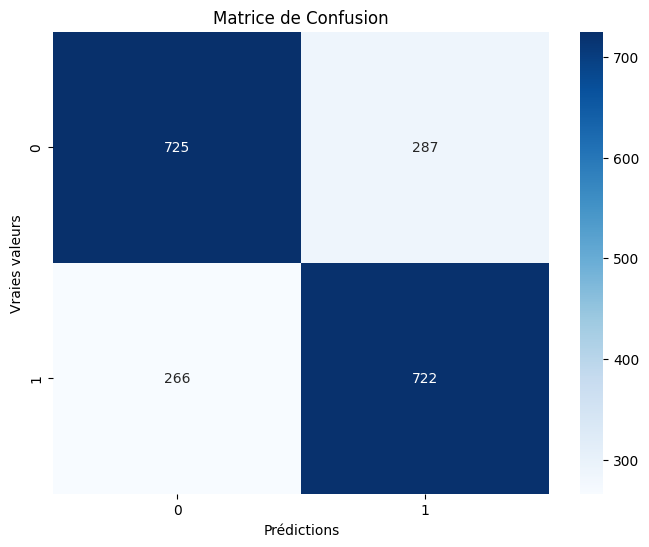

In [ ]:
y_pred = modeleBi.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 100)          100000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 100, 256)          234496    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 100, 256)          0         
                                                                 
 dense_1 (Dense)             (None, 100, 64)           16448     
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               66048     
 onal)                                                     

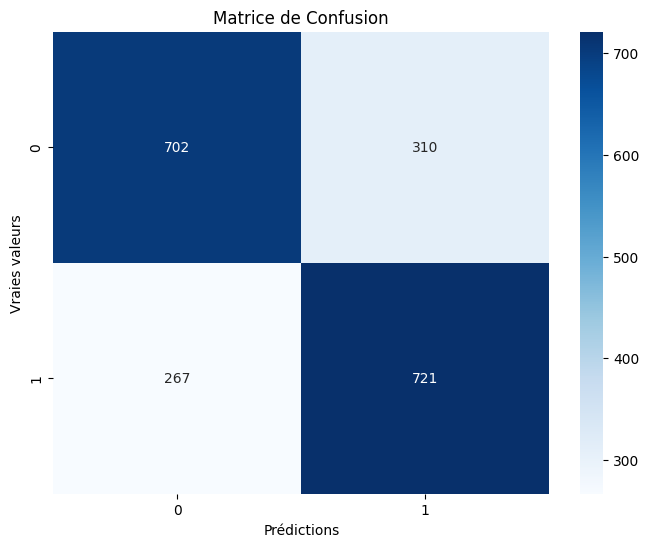

In [ ]:
inputs_bi = Input(shape=(max_len,))
embedding_layer_bi = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(inputs_bi)

x_bi = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer_bi)
x_bi = Dropout(0.2)(x_bi)
x_bi = Dense(64)(x_bi)
x_bi = Bidirectional(LSTM(64))(x_bi)
x_bi = Dropout(0.2)(x_bi)

outputs_bi = Dense(1, activation='sigmoid')(x_bi)

modeleBi = Model(inputs=inputs_bi, outputs=outputs_bi)

print(modeleBi.summary())

optimizer = Adam(learning_rate=learning_rate)

modeleBi.compile(loss='binary_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_bi = modeleBi.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

loss_bi, accuracy_bi = modeleBi.evaluate(X_test, y_test)
print("Test Loss (BiLSTM):", loss_bi)
print("Test Accuracy (BiLSTM):", accuracy_bi)

y_pred = modeleBi.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 100, 100)          100000    
                                                                 
 bidirectional_4 (Bidirecti  (None, 100, 128)          84480     
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 100, 128)          0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 128)               0   

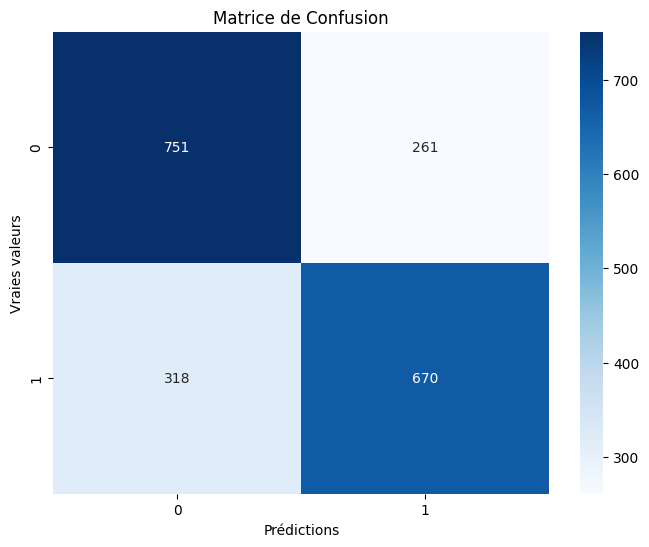

In [ ]:
inputs_bi = Input(shape=(max_len,))
embedding_layer_bi = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(inputs_bi)

x_bi = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer_bi)
x_bi = Dropout(0.2)(x_bi)
x_bi = Bidirectional(LSTM(64))(x_bi)
x_bi = Dropout(0.2)(x_bi)

outputs_bi = Dense(1, activation='sigmoid')(x_bi)

modeleBi = Model(inputs=inputs_bi, outputs=outputs_bi)

print(modeleBi.summary())
learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)

modeleBi.compile(loss='binary_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_bi = modeleBi.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

loss_bi, accuracy_bi = modeleBi.evaluate(X_test, y_test)
print("Test Loss (BiLSTM):", loss_bi)
print("Test Accuracy (BiLSTM):", accuracy_bi)

y_pred = modeleBi.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 100, 100)          100000    
                                                                 
 bidirectional_6 (Bidirecti  (None, 100, 128)          84480     
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 100, 128)          0         
                                                                 
 bidirectional_7 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 64)                0   

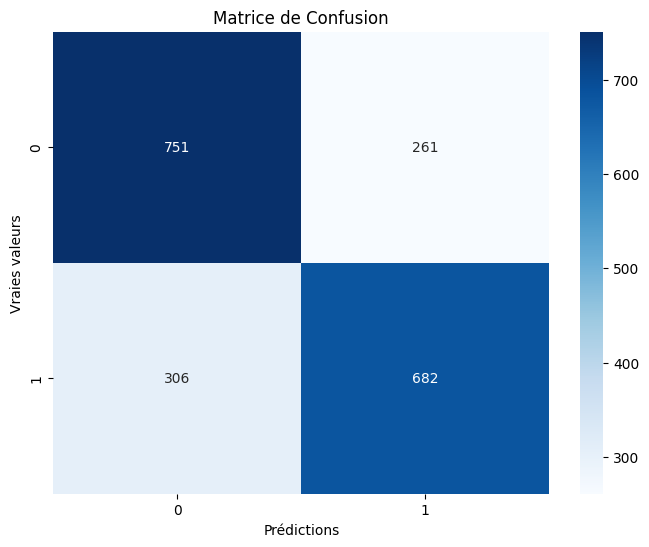

In [ ]:
inputs_bi = Input(shape=(max_len,))
embedding_layer_bi = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(inputs_bi)

x_bi = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer_bi)
x_bi = Dropout(0.2)(x_bi)
x_bi = Bidirectional(LSTM(32))(x_bi)
x_bi = Dropout(0.2)(x_bi)

outputs_bi = Dense(1, activation='sigmoid')(x_bi)

modeleBi = Model(inputs=inputs_bi, outputs=outputs_bi)

print(modeleBi.summary())
learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)

modeleBi.compile(loss='binary_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_bi = modeleBi.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

loss_bi, accuracy_bi = modeleBi.evaluate(X_test, y_test)
print("Test Loss (BiLSTM):", loss_bi)
print("Test Accuracy (BiLSTM):", accuracy_bi)

y_pred = modeleBi.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()